This notebook calculates the topic model of the craving set, it clusters into 10 different topics

In [ ]:
#https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/ 
#Run in python console
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [ ]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [ ]:
# Import Dataset
df = pd.read_csv("Data/craving_words.csv")
df.head()

,post
0,The cravings….\nThe cravings suck. I’m only da...
1,Day 235 — would like to tune my sleep\nIf I ea...
2,Hard few days\nHit my first rough patch after ...
3,Stories on delirium tremens?\nDoes anyone have...
4,Day 5 today! Woot woot!\nSo happy that today i...


In [ ]:
# Convert to list
data = df.post.values.tolist()

# Remove new line characters
data = [re.sub('\s+', ' ', post) for post in data]

# Remove distracting single quotes
data = [re.sub("\'", "", post) for post in data]

pprint(data[:1])

['The cravings…. The cravings suck. I’m only day 2 and all I can think about '
 'is wanting a drink. I don’t even like the flavor of alcohol or enjoy wine '
 'etc. but the feeling is what I like. 😩. I’ve been distracting myself today '
 'too and been busy but I feel very on edge and keep telling myself it’ll Be '
 'worth it. How long do the cravings last?']


In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

data_words = [[word for word in words if len(word)>2] for words in data_words]    

print(data_words[:1])

[['the', 'cravings', 'the', 'cravings', 'suck', 'only', 'day', 'and', 'all', 'can', 'think', 'about', 'wanting', 'drink', 'don', 'even', 'like', 'the', 'flavor', 'alcohol', 'enjoy', 'wine', 'etc', 'but', 'the', 'feeling', 'what', 'like', 'been', 'distracting', 'myself', 'today', 'too', 'and', 'been', 'busy', 'but', 'feel', 'very', 'edge', 'and', 'keep', 'telling', 'myself', 'worth', 'how', 'long', 'the', 'cravings', 'last']]


In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['the', 'cravings', 'the', 'cravings', 'suck', 'only', 'day', 'and', 'all', 'can', 'think', 'about', 'wanting', 'drink', 'don', 'even', 'like', 'the', 'flavor', 'alcohol', 'enjoy', 'wine', 'etc', 'but', 'the', 'feeling', 'what', 'like', 'been', 'distracting', 'myself', 'today', 'too', 'and', 'been', 'busy', 'but', 'feel', 'very', 'edge', 'and', 'keep', 'telling', 'myself', 'worth', 'how', 'long', 'the', 'cravings', 'last']


In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['day', 'think', 'want', 'drink', 'even', 'flavor', 'alcohol', 'enjoy', 'wine', 'feeling', 'distract', 'today', 'busy', 'feel', 'edge', 'keep', 'tell', 'worth', 'long', 'craving', 'last']]


In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1)]]


In [ ]:
id2word[0]

'alcohol'

In [ ]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('alcohol', 1),
  ('busy', 1),
  ('craving', 1),
  ('day', 1),
  ('distract', 1),
  ('drink', 1),
  ('edge', 1),
  ('enjoy', 1),
  ('even', 1),
  ('feel', 1),
  ('feeling', 1),
  ('flavor', 1),
  ('keep', 1),
  ('last', 1),
  ('long', 1),
  ('tell', 1),
  ('think', 1),
  ('today', 1),
  ('want', 1),
  ('wine', 1),
  ('worth', 1)]]

In [ ]:
import time
# Build LDA model
numTopicsRange = [3,5,7,10,15,20]
validationPerplexity = []
coherences = []
timeElapsed = []
lda_models = []
for i in numTopicsRange:
    start = time.time()
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=i, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    end = time.time()
    validationPerplexity.append(lda_model.log_perplexity(corpus))
    coherences.append(CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v').get_coherence())
    lda_models.append(lda_model)
    timeElapsed.append(end-start) 

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(9, 3.5), dpi=1600)
seconds = [t/100 for t in timeElapsed]
plt.plot(numTopicsRange,validationPerplexity, color = 'r', label = 'Validation perplexity')
#plt.plot(numTopicsRange,seconds, color = 'b', label = 'time elapsed')
plt.xticks(numTopicsRange)
plt.xlabel("Number of Topics")
plt.legend(loc='upper left')
plt.show()

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(9, 3.5), dpi=1600)
seconds = [t/100 for t in timeElapsed]
plt.plot(numTopicsRange,coherences, color = 'b', label = 'Coherence Score')
#plt.plot(numTopicsRange,seconds, color = 'b', label = 'time elapsed')
plt.xticks(numTopicsRange)
plt.xlabel("Number of Topics")
plt.legend(loc='upper left')
plt.show()

In [ ]:
# Print the Keyword in the 10 topics
best_idx = 0
pprint(lda_models[best_idx].print_topics())
doc_lda = lda_models[best_idx][corpus]

[(0,
  '0.061*"eat" + 0.043*"amp" + 0.029*"food" + 0.023*"weight" + 0.021*"body" + '
  '0.021*"coffee" + 0.019*"water" + 0.019*"smoke" + 0.015*"here" + '
  '0.015*"exercise"'),
 (1,
  '0.035*"get" + 0.027*"go" + 0.021*"home" + 0.017*"tell" + 0.014*"say" + '
  '0.012*"leave" + 0.011*"come" + 0.011*"fuck" + 0.010*"tonight" + '
  '0.010*"call"'),
 (2,
  '0.050*"job" + 0.029*"move" + 0.022*"money" + 0.021*"family" + 0.020*"live" '
  '+ 0.019*"pain" + 0.018*"parent" + 0.017*"die" + 0.016*"due" + 0.013*"kill"'),
 (3,
  '0.030*"meeting" + 0.025*"experience" + 0.024*"people" + 0.019*"learn" + '
  '0.017*"share" + 0.016*"step" + 0.015*"other" + 0.013*"group" + 0.012*"read" '
  '+ 0.012*"book"'),
 (4,
  '0.078*"day" + 0.055*"feel" + 0.034*"get" + 0.031*"go" + 0.027*"week" + '
  '0.027*"today" + 0.024*"last" + 0.019*"work" + 0.018*"well" + '
  '0.017*"craving"'),
 (5,
  '0.025*"time" + 0.022*"know" + 0.020*"want" + 0.019*"ve" + 0.019*"year" + '
  '0.019*"make" + 0.016*"think" + 0.016*"sober" + 0.

In [ ]:
print(lda_models[best_idx].top_topics(corpus))

[([(0.025227653, 'time'), (0.021965794, 'know'), (0.019680517, 'want'), (0.019408023, 've'), (0.01900805, 'year'), (0.018620025, 'make'), (0.016099883, 'think'), (0.016025668, 'sober'), (0.01587795, 'thing'), (0.015730636, 'life'), (0.01163968, 'try'), (0.010743117, 'help'), (0.010554222, 'need'), (0.01002695, 'get'), (0.009875223, 'month'), (0.009404009, 'relapse'), (0.009369869, 'never'), (0.009218915, 'way'), (0.009103537, 'even'), (0.0090760635, 'alcohol')], -0.9030842630977544), ([(0.077582896, 'day'), (0.054643705, 'feel'), (0.033784915, 'get'), (0.031163653, 'go'), (0.027300393, 'week'), (0.027053496, 'today'), (0.023627073, 'last'), (0.019278003, 'work'), (0.017535768, 'well'), (0.017454749, 'craving'), (0.015089315, 'start'), (0.014648333, 'really'), (0.0144785335, 'good'), (0.012828696, 'bad'), (0.012557715, 'first'), (0.009820767, 'time'), (0.0091203675, 'feeling'), (0.009103518, 'still'), (0.009035451, 'wake'), (0.008491662, 've')], -1.0252684128010867), ([(0.03532358, 'get

In [ ]:
sent_topics_df = pd.DataFrame()
for i, row_list in enumerate(doc_lda):
        row = row_list[0] if lda_models[best_idx].per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = lda_models[3].show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
sent_topics_df


In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_models[best_idx].log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_models[best_idx], texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.131806181123623

Coherence Score:  0.38228650546723997


In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_models[best_idx], corpus, id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.276716 -0.040870       1        1  38.710625
4      0.277267  0.064608       2        1  22.602912
1      0.216805  0.092335       3        1  12.818046
6      0.099740  0.025224       4        1  10.251997
3     -0.036864 -0.409146       5        1   5.484811
2     -0.134017  0.161039       6        1   3.331991
0     -0.191351  0.085537       7        1   2.294986
7     -0.182359  0.009725       8        1   1.713052
9     -0.110348 -0.019087       9        1   1.408150
8     -0.215588  0.030637      10        1   1.383430, topic_info=              Term           Freq          Total Category  logprob  loglift
5            drink  101937.000000  101937.000000  Default  30.0000  30.0000
3              day   72900.000000   72900.000000  Default  29.0000  29.0000
9             feel   55141.000000   55141.000000  Default  28.0000  28.0000
34             get   66705.000000   66705.000000  Default  27.0000  27.0000
81              go   45731.000000   45731.000000  Default  26.0000  26.0000
...            ...            ...            ...      ...      ...      ...
3516         tooth     302.965616     303.815087  Topic10  -5.2461   4.2778
1142  prescription     260.930340     261.779690  Topic10  -5.3955   4.2774
540       hospital     885.986135    1519.965317  Topic10  -4.1730   3.7409
328           test     646.549129    1351.821253  Topic10  -4.4881   3.5430
171     withdrawal     409.490696    1623.765986  Topic10  -4.9448   2.9030

[504 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1397      5  0.998597    ability
968       8  0.999551      abuse
1622      5  0.999004     action
707       8  0.999379     addict
1035      8  0.997862   addicted
...     ...       ...        ...
336       2  0.998860  yesterday
336       3  0.000846  yesterday
337       1  0.999651        yet
4032      7  0.997356       yoga
338       6  0.999119      young

[687 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 5, 2, 7, 4, 3, 1, 8, 10, 9])

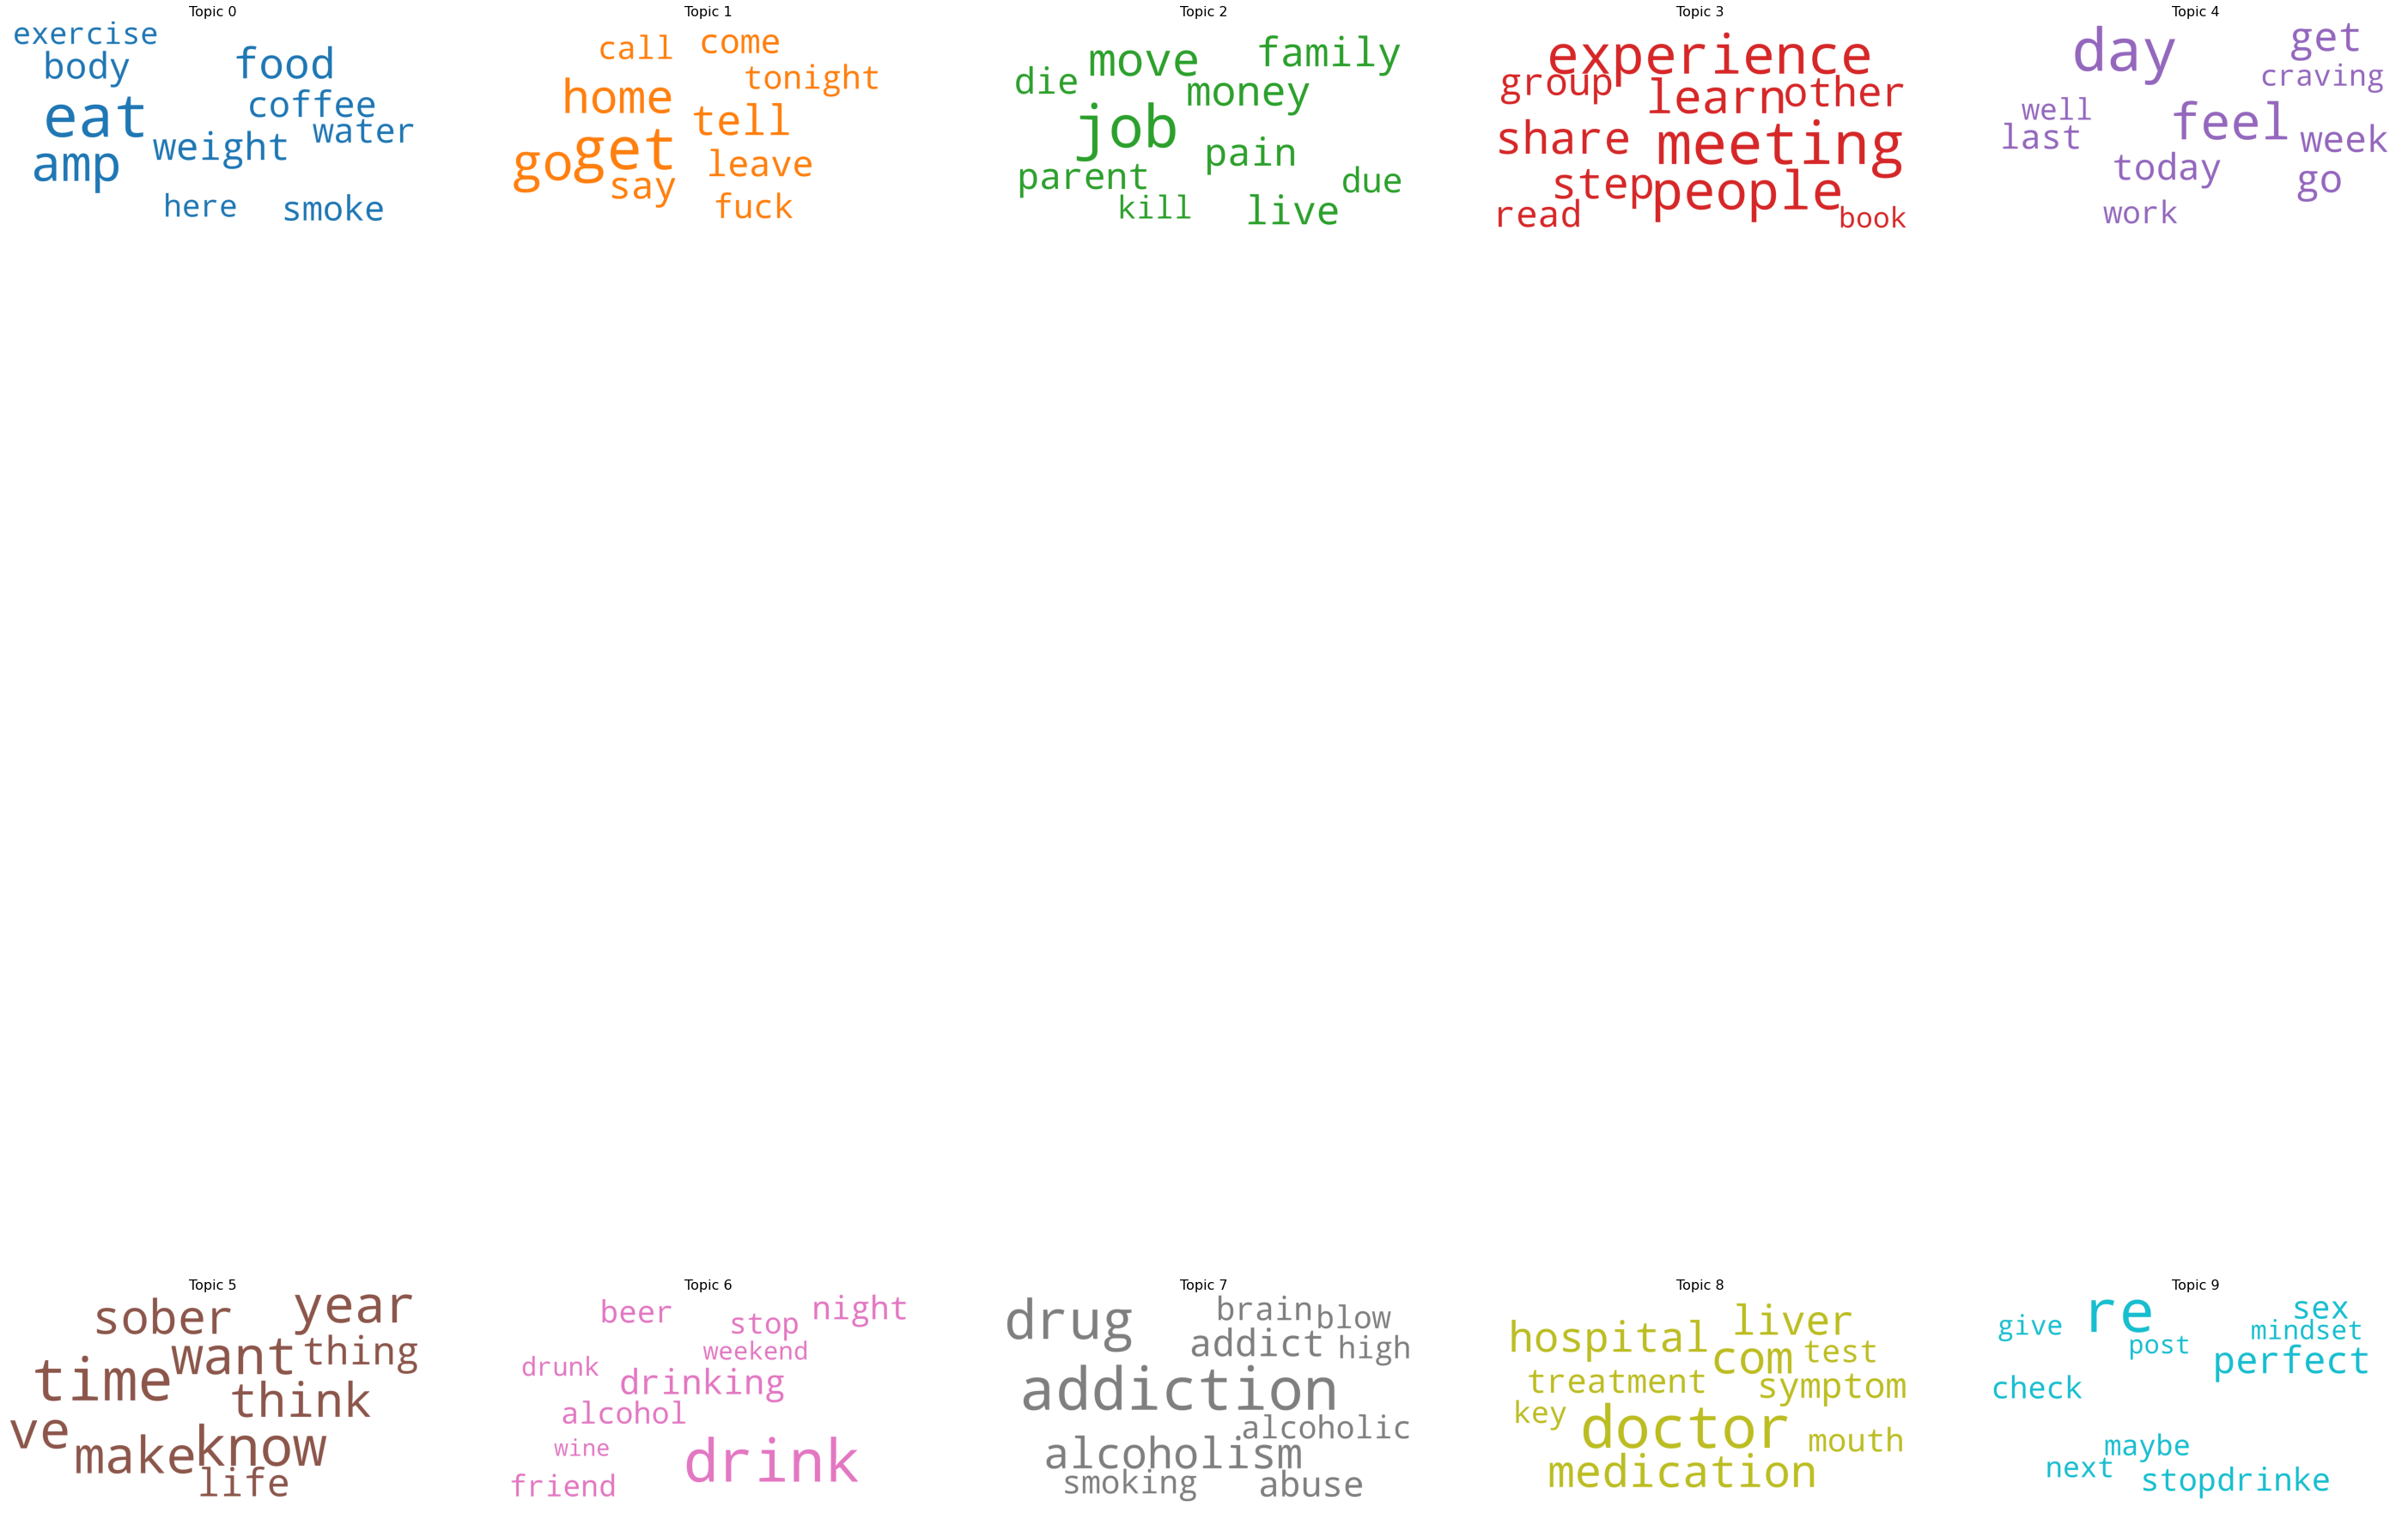

In [ ]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=3500,
                  height=1800,
                  max_words=14,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_models[best_idx].show_topics(formatted=False)

fig, axes = plt.subplots(2, 5, figsize=(50,50), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=500)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.figure(figsize=(9, 3.5), dpi=1600)
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()
'''plt.savefig("wordclouds", 
                          dpi=3600,
                          facecolor='w',
                          edgecolor='w',
                          orientation='portrait',
                          papertype=None, 
                          format=None,
                          transparent=False,
                          bbox_inches=None, 
                          pad_inches=0.1,
                          frameon=None, 
                          metadata=None)'''

In [ ]:
pyLDAvis.save_html(vis, 'lda.html')